In [62]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split

In [4]:
#file paths
client_data_path = "../data/client_data/"
external_data_path = "../data/external_data/"

In [6]:
df_client = pd.read_csv(client_data_path+"client_data.csv")
df_price = pd.read_csv(client_data_path+"price_data.csv")

# Pricing EDA

In [8]:
df_price.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


* large skew for all of the continuous variables, judging by the distances between the quartiles and the min/max. In particular, likely lot of zeros, we need to interpret those (could be customers that have not renewed their contract/de-activated)
* large difference between var and fix variables, no real sense of meaning here

In [9]:
df_price.describe()

,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
count,193002.000000,193002.000000,193002.000000,193002.000000,193002.000000,193002.000000
mean,0.141027,0.054630,0.030496,43.334477,10.622875,6.409984
std,0.025032,0.049924,0.036298,5.410297,12.841895,7.773592
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.125976,0.000000,0.000000,40.728885,0.000000,0.000000
50%,0.146033,0.085483,0.000000,44.266930,0.000000,0.000000
75%,0.151635,0.101673,0.072558,44.444710,24.339581,16.226389
max,0.280700,0.229788,0.114102,59.444710,36.490692,17.458221


16,096 unique customers in the pricing dataset

In [ ]:
len(df_price.id.unique())

16096

* if the off peak var is non-zero then you can still have the peak and mid be 0
* the fixed_var have little variation and therefore might imply something about size of the business?

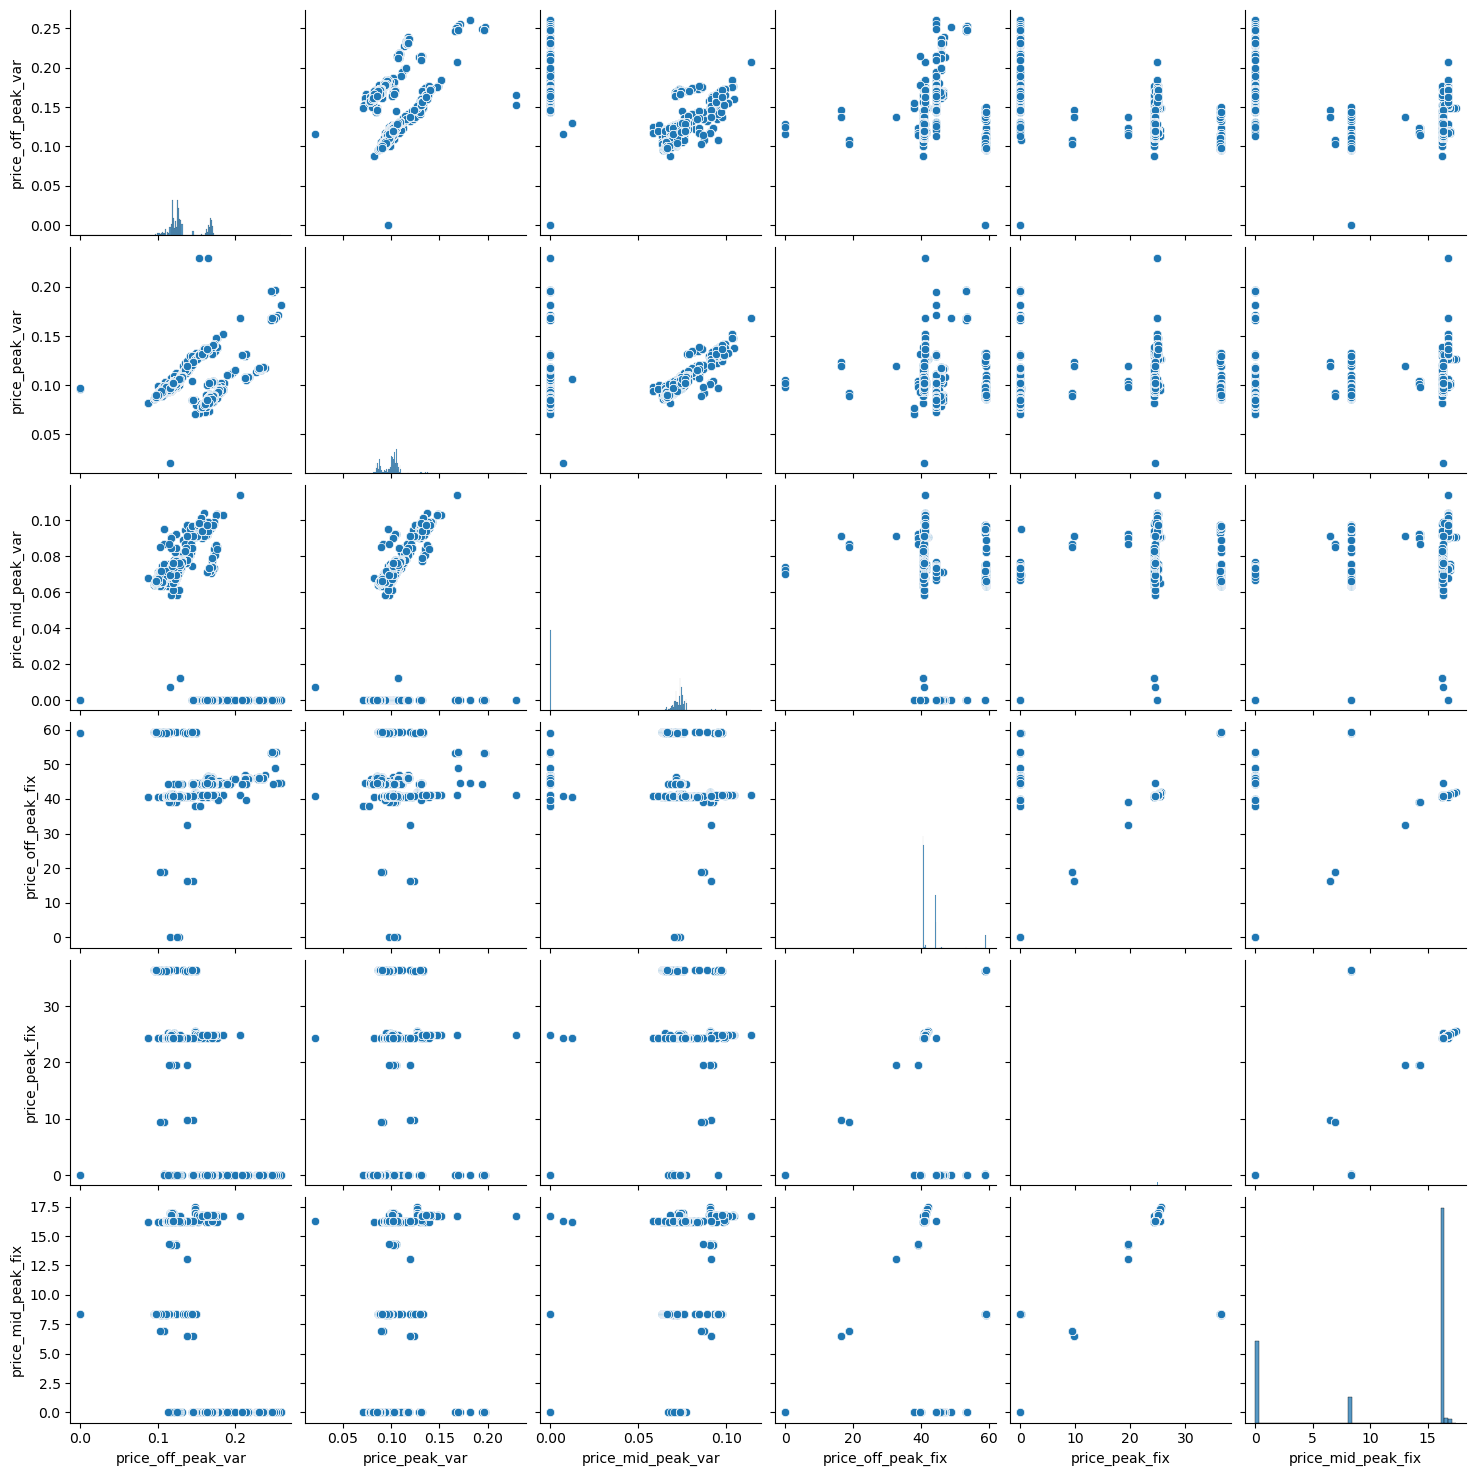

In [17]:
sns.pairplot(data=df_price.query('price_peak_var > 0'))

For more than half of the transaction the mid_peak_var is zero. Is this due to 

# Client EDA

In [40]:
df_client.dtypes

id                                        object
channel_sales                             object
cons_12m                                   int64
cons_gas_12m                               int64
cons_last_month                            int64
date_activ                        datetime64[ns]
date_end                          datetime64[ns]
date_modif_prod                   datetime64[ns]
date_renewal                      datetime64[ns]
forecast_cons_12m                        float64
forecast_cons_year                         int64
forecast_discount_energy                 float64
forecast_meter_rent_12m                  float64
forecast_price_energy_off_peak           float64
forecast_price_energy_peak               float64
forecast_price_pow_off_peak              float64
has_gas                                   object
imp_cons                                 float64
margin_gross_pow_ele                     float64
margin_net_pow_ele                       float64
nb_prod_act         

In [35]:
df_client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              14606 non-null  object        
 1   channel_sales                   14606 non-null  object        
 2   cons_12m                        14606 non-null  int64         
 3   cons_gas_12m                    14606 non-null  int64         
 4   cons_last_month                 14606 non-null  int64         
 5   date_activ                      14606 non-null  datetime64[ns]
 6   date_end                        14606 non-null  datetime64[ns]
 7   date_modif_prod                 14606 non-null  datetime64[ns]
 8   date_renewal                    14606 non-null  datetime64[ns]
 9   forecast_cons_12m               14606 non-null  float64       
 10  forecast_cons_year              14606 non-null  int64         
 11  fo

In [39]:
df_client.nunique()

id                                14606
channel_sales                         8
cons_12m                          11065
cons_gas_12m                       2112
cons_last_month                    4751
date_activ                         1796
date_end                            368
date_modif_prod                    2129
date_renewal                        386
forecast_cons_12m                 13993
forecast_cons_year                 4218
forecast_discount_energy             12
forecast_meter_rent_12m            3528
forecast_price_energy_off_peak      516
forecast_price_energy_peak          329
forecast_price_pow_off_peak          41
has_gas                               2
imp_cons                           7752
margin_gross_pow_ele               2391
margin_net_pow_ele                 2391
nb_prod_act                          10
net_margin                        11965
num_years_antig                      13
origin_up                             6
pow_max                             698


In [44]:
tmp_dict = {'f':0,'t':1}
df_client['has_gas'] = df_client['has_gas'].map(tmp_dict)

# Feature Engineering

In [45]:
data_cols = ['date_activ','date_end','date_modif_prod','date_renewal']
int_cols = ['has_gas','churn']
df_client[data_cols] = df_client[data_cols].apply(pd.to_datetime, errors = 'coerce')
df_client[int_cols] = df_client[int_cols].apply(np.int64)

In [33]:
df_client['year_active'] = df_client['date_activ'].dt.year
df_client['month_active'] = df_client['date_activ'].dt.month
df_client['year_end'] = df_client['date_end'].dt.year
df_client['month_end'] = df_client['date_end'].dt.month

df_client['year_modif'] = df_client['date_modif_prod'].dt.year
df_client['month_modif'] = df_client['date_modif_prod'].dt.month
df_client['year_renewal'] = df_client['date_renewal'].dt.year
df_client['month_renewal'] = df_client['date_renewal'].dt.month

In [47]:
df_client.churn.describe()
#only <10% of clients have churn according to this metric

count    14606.000000
mean         0.097152
std          0.296175
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: churn, dtype: float64

In [50]:
df_client.corr(numeric_only=True)
#nothing horribly related to the churn value

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,...,pow_max,churn,year_active,month_active,year_end,month_end,year_modif,month_modif,year_renewal,month_renewal
cons_12m,1.000000,0.488474,0.968212,0.193947,0.167093,-0.043282,0.065268,-0.007748,0.145908,-0.026566,...,0.082889,-0.045968,0.023610,-0.042148,-0.001105,-0.048059,-0.114380,-0.047227,0.009908,-0.045194
cons_gas_12m,0.488474,1.000000,0.507007,0.084359,0.080934,-0.012595,0.041393,-0.017684,0.074002,-0.020558,...,0.054317,-0.037957,0.019082,-0.020520,0.022271,-0.009404,-0.048106,-0.022243,0.020409,-0.007864
cons_last_month,0.968212,0.507007,1.000000,0.177773,0.193574,-0.040874,0.057476,-0.005187,0.136802,-0.023017,...,0.074529,-0.045284,0.021991,-0.035763,0.004421,-0.041881,-0.110771,-0.040891,0.016276,-0.041012
forecast_cons_12m,0.193947,0.084359,0.177773,1.000000,0.647727,0.058435,0.305627,-0.135646,0.254056,-0.018477,...,0.393946,0.012949,-0.007246,-0.050232,0.011407,-0.070816,-0.006403,-0.048829,-0.029218,-0.048030
forecast_cons_year,0.167093,0.080934,0.193574,0.647727,1.000000,0.008518,0.276009,-0.158012,0.251005,-0.044190,...,0.309647,-0.002558,-0.031805,-0.055508,0.025425,-0.072945,-0.037987,-0.065718,0.007216,-0.061111
forecast_discount_energy,-0.043282,-0.012595,-0.040874,0.058435,0.008518,1.000000,-0.008388,0.353735,0.059318,0.048024,...,-0.005032,0.017026,0.078031,-0.047484,-0.008760,-0.054564,0.182590,0.015973,-0.166071,-0.039639
forecast_meter_rent_12m,0.065268,0.041393,0.057476,0.305627,0.276009,-0.008388,1.000000,-0.579353,0.706376,-0.203089,...,0.618549,0.044245,-0.057408,-0.053913,0.010902,-0.043982,-0.010949,-0.128384,0.052812,-0.078946
forecast_price_energy_off_peak,-0.007748,-0.017684,-0.005187,-0.135646,-0.158012,0.353735,-0.579353,1.000000,-0.330138,0.630377,...,-0.384397,-0.010837,0.157627,0.024343,-0.040348,0.014354,0.090807,0.094362,-0.122688,0.037048
forecast_price_energy_peak,0.145908,0.074002,0.136802,0.254056,0.251005,0.059318,0.706376,-0.330138,1.000000,-0.242017,...,0.411532,0.029315,-0.069957,-0.036498,-0.015642,-0.040301,-0.033402,-0.137496,-0.013850,-0.051307
forecast_price_pow_off_peak,-0.026566,-0.020558,-0.023017,-0.018477,-0.044190,0.048024,-0.203089,0.630377,-0.242017,1.000000,...,-0.095897,0.014778,0.101994,0.063048,-0.054626,0.081223,0.075296,0.088206,0.002235,0.024436


C:\Users\Hamilton Greg\AppData\Local\Temp\ipykernel_22088\3812601312.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


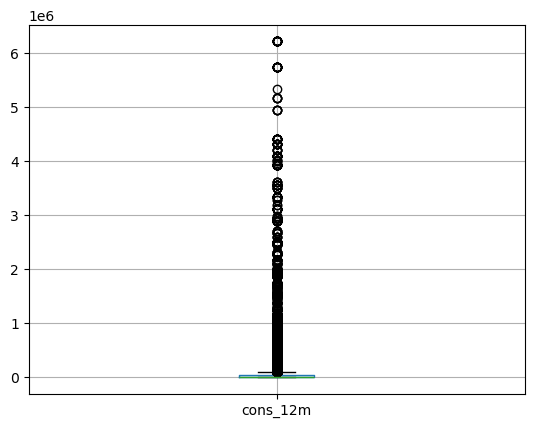

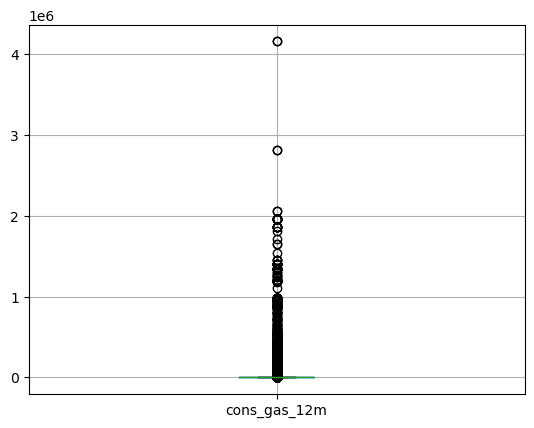

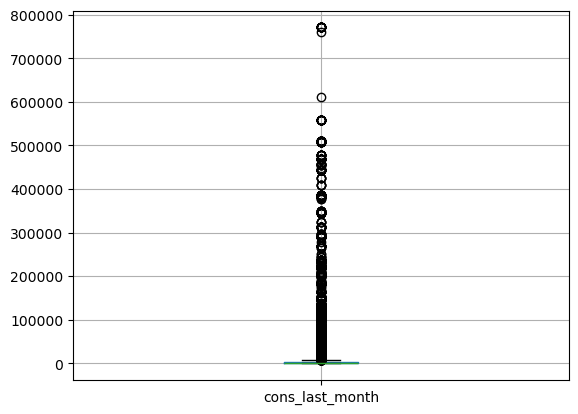

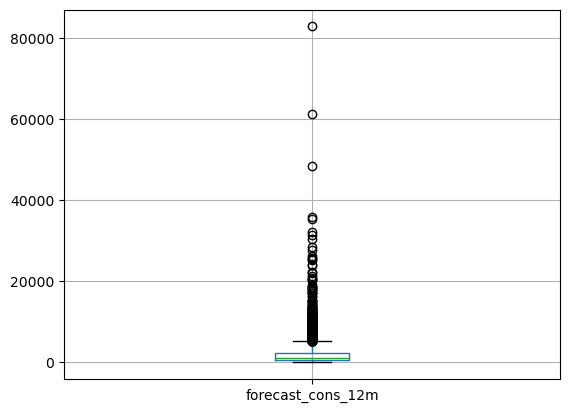

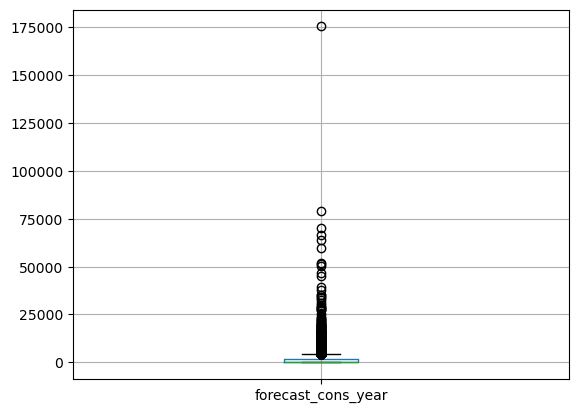

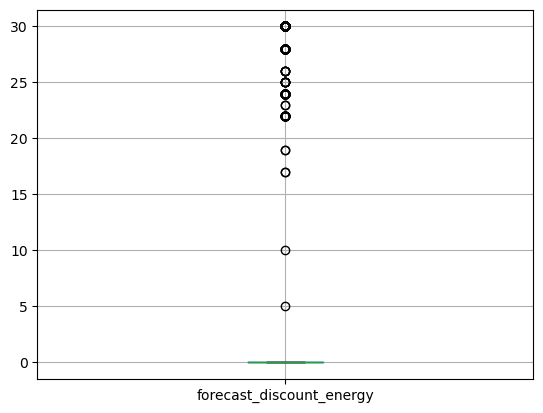

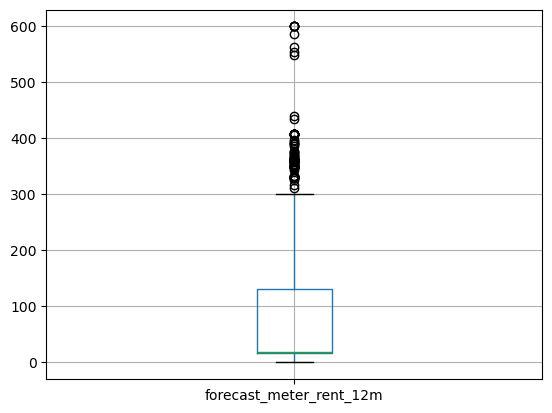

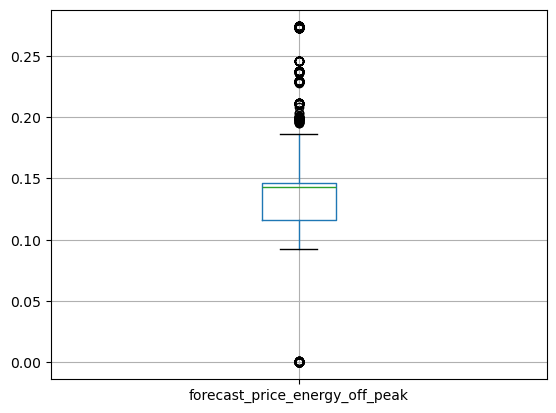

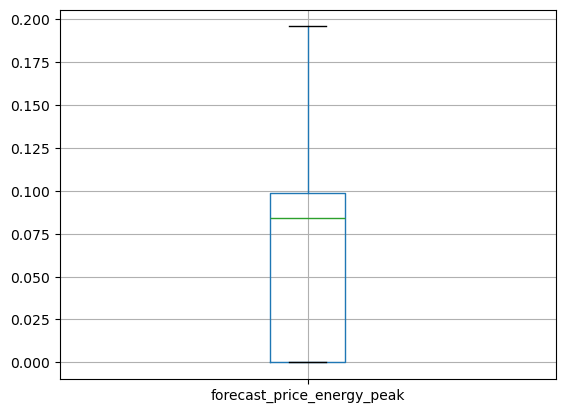

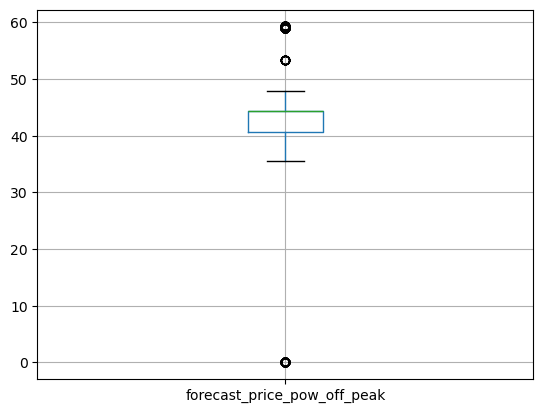

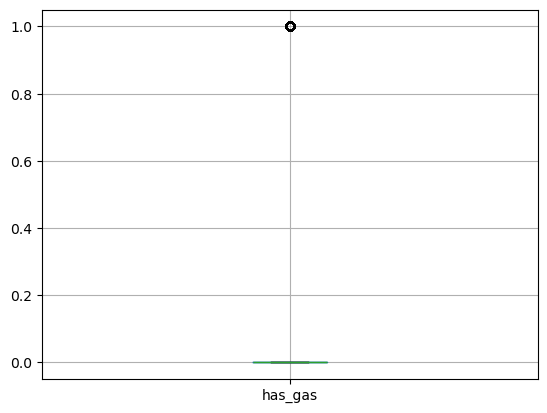

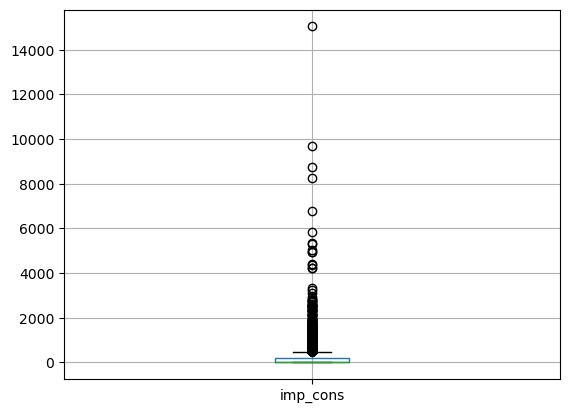

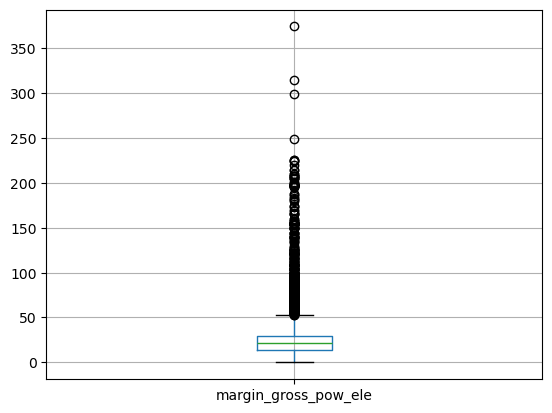

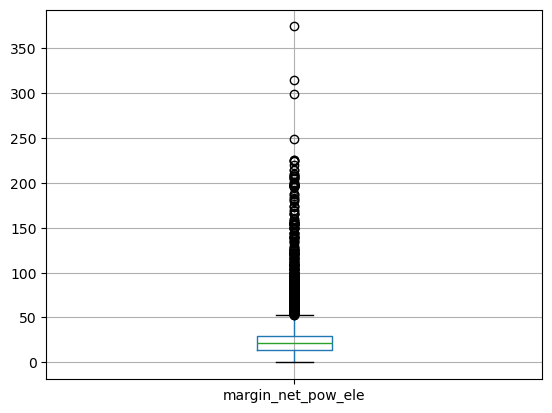

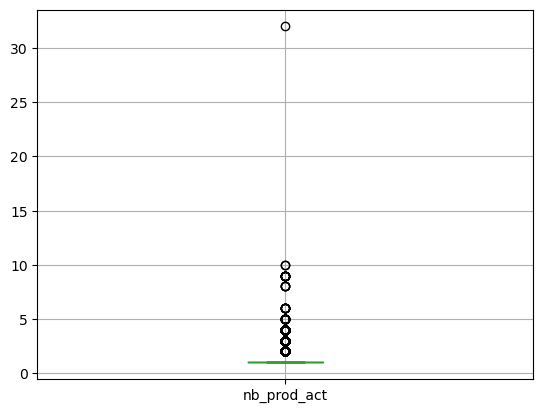

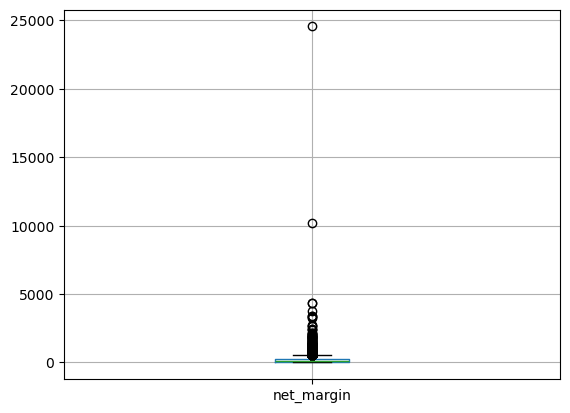

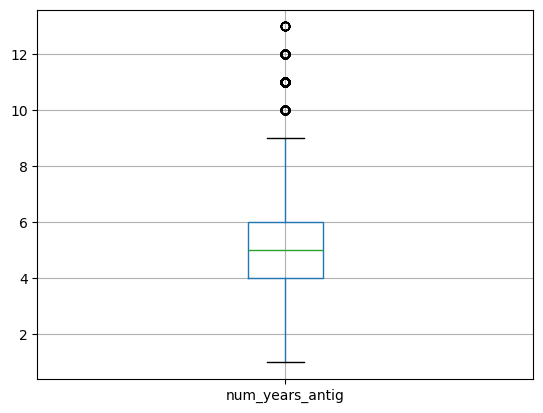

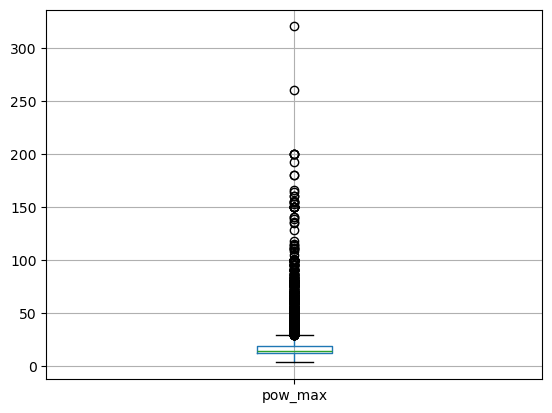

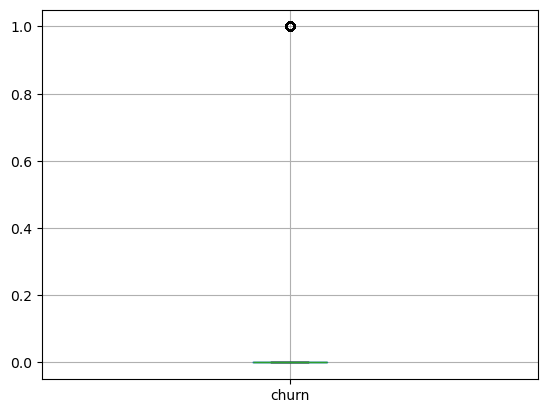

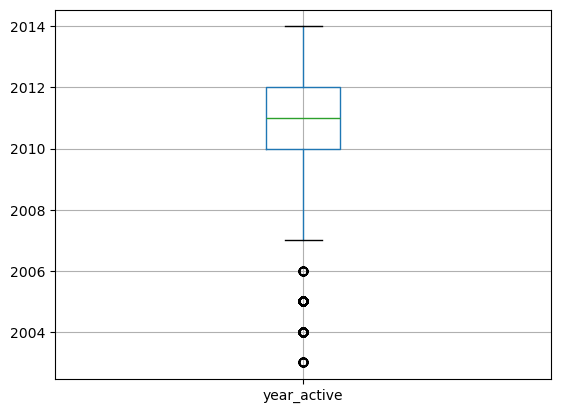

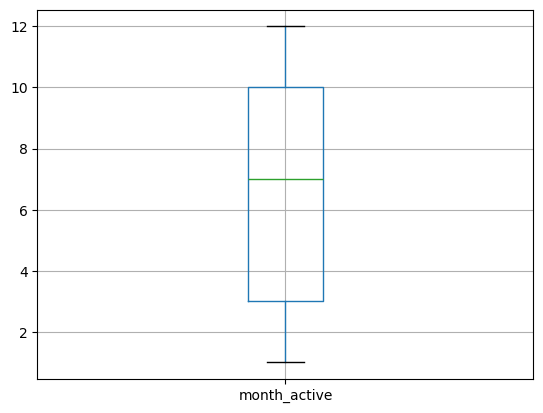

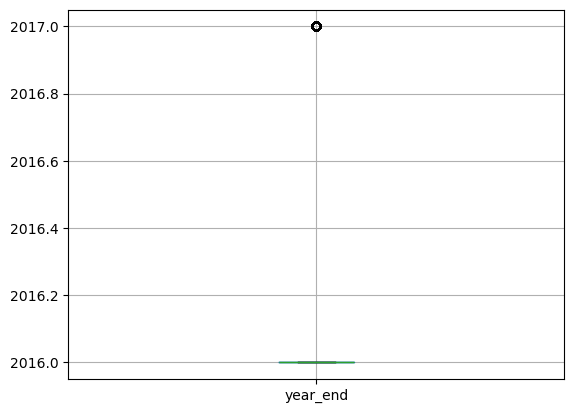

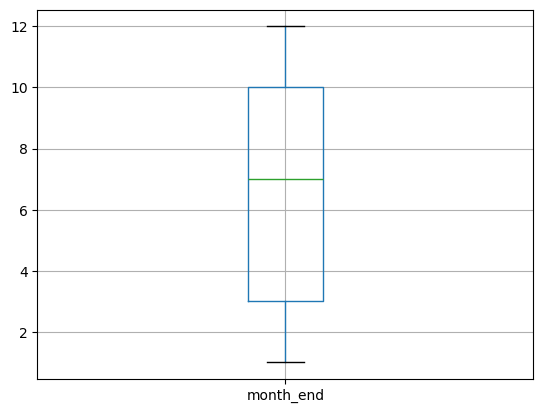

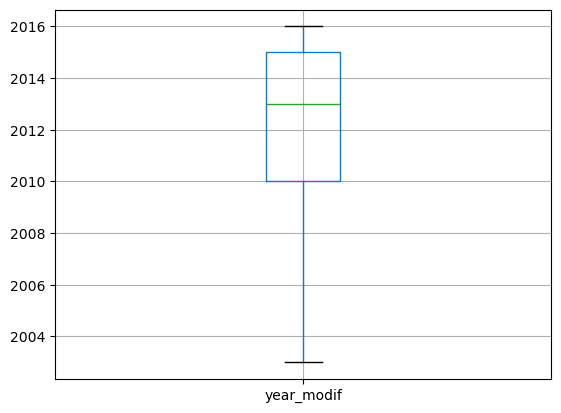

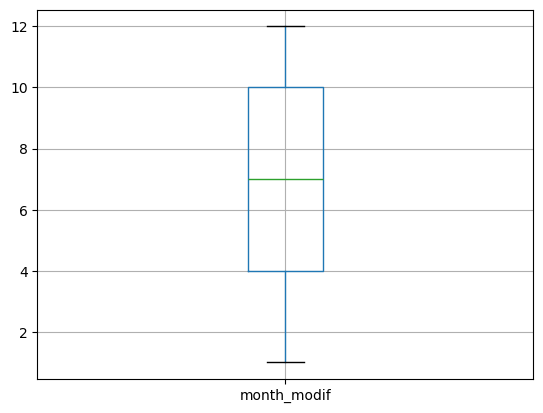

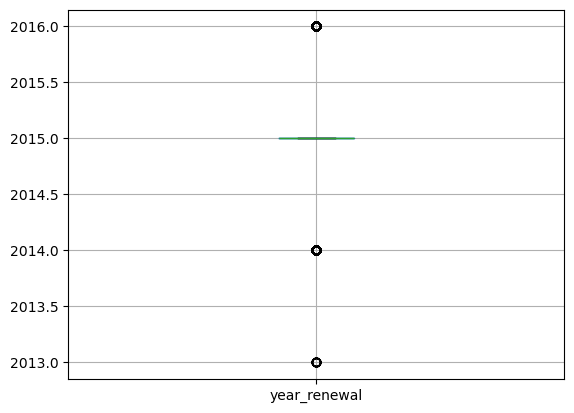

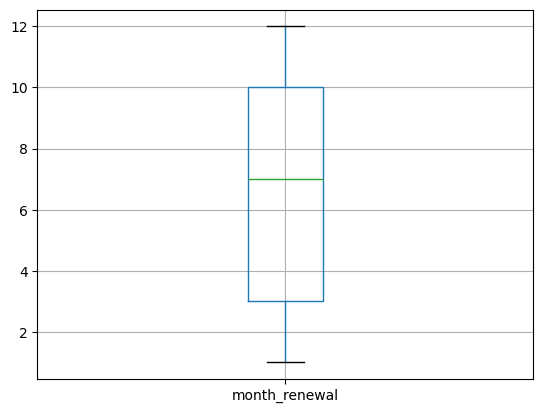

In [56]:
df_numeric = df_client.select_dtypes(include= "number") 
for c in df_numeric:
    plt.figure()
    df_numeric.boxplot([c])
    

In [55]:
cont_cols

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,...,pow_max,churn,year_active,month_active,year_end,month_end,year_modif,month_modif,year_renewal,month_renewal
0,0,54946,0,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,...,43.648,1,2013,6,2016,6,2015,11,2015,6
1,4660,0,0,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,...,13.800,0,2009,8,2016,8,2009,8,2015,8
2,544,0,0,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,...,13.856,0,2010,4,2016,4,2010,4,2015,4
3,1584,0,0,240.04,0,0.0,19.83,0.146694,0.000000,44.311378,...,13.200,0,2010,3,2016,3,2010,3,2015,3
4,4425,0,526,445.75,526,0.0,131.73,0.116900,0.100015,40.606701,...,19.800,0,2010,1,2016,3,2010,1,2015,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14601,32270,47940,0,4648.01,0,0.0,18.57,0.138305,0.000000,44.311378,...,15.000,0,2012,5,2016,5,2015,5,2014,5
14602,7223,0,181,631.69,181,0.0,144.03,0.100167,0.091892,58.995952,...,6.000,1,2012,8,2016,8,2012,8,2015,8
14603,1844,0,179,190.39,179,0.0,129.60,0.116900,0.100015,40.606701,...,15.935,1,2012,2,2016,2,2012,2,2015,2
14604,131,0,0,19.34,0,0.0,7.18,0.145711,0.000000,44.311378,...,11.000,0,2012,8,2016,8,2012,8,2015,8


# Building momentum: logistic regression

In [59]:
X_train, X_test, y_train, y_test = train_test_split(df_numeric.drop('churn', axis =1), df_numeric['churn'],random_state=1234, test_size=.2)

In [61]:
log_model = LogisticRegression()
#we need to standardize prior to this point, hence need for transformation pipeline so we can test multiple models and compare predictability
log_model.fit(X_train, y_train)

c:\Users\Hamilton Greg\Anaconda3\envs\bcg_X_practice\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [63]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()